In [1]:
import pandas as pd
import datetime
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score ,roc_auc_score, explained_variance_score, mean_squared_error, r2_score, plot_roc_curve

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.9.0+cu111
Populating the interactive namespace from numpy and matplotlib


# Data Preparation

In [2]:
train_df = pd.read_csv('./results/qsofa_train.csv', index_col=0)
valid_df = pd.read_csv('./results/qsofa_valid.csv', index_col=0)
test_df = pd.read_csv('./results/qsofa_test.csv', index_col=0)

In [3]:
train_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'hr', 'endtime', 'sbp', 'gcs_min',
       'respiratory_rate', 'abp_mean', 'heart_rate', 'SaO2', 'fio2', 'event'],
      dtype='object')

In [4]:
train_df.head(10)

,subject_id,hadm_id,stay_id,hr,endtime,sbp,gcs_min,respiratory_rate,abp_mean,heart_rate,SaO2,fio2,event
starttime,,,,,,,,,,,,,
2179-03-10 00:00:00,11825239,28824872,35951106,0,2179-03-10 01:00:00,0.468085,1.0,0.003729,0.097744,0.000454,0.00001,0.0,0
2179-03-10 01:00:00,11825239,28824872,35951106,1,2179-03-10 02:00:00,0.471631,1.0,0.004634,0.097744,0.000454,0.00001,0.0,0
2179-03-10 02:00:00,11825239,28824872,35951106,2,2179-03-10 03:00:00,0.472961,1.0,0.004474,0.097744,0.000526,0.00001,0.0,0
2179-03-10 03:00:00,11825239,28824872,35951106,3,2179-03-10 04:00:00,0.474291,1.0,0.007031,0.097744,0.000434,0.00001,0.0,0
2179-03-10 04:00:00,11825239,28824872,35951106,4,2179-03-10 05:00:00,0.475621,1.0,0.007990,0.097744,0.000500,0.00001,0.0,0
2179-03-10 05:00:00,11825239,28824872,35951106,5,2179-03-10 06:00:00,0.476950,1.0,0.007351,0.097744,0.000480,0.00001,0.0,0
2179-03-10 06:00:00,11825239,28824872,35951106,6,2179-03-10 07:00:00,0.478280,1.0,0.005753,0.097744,0.000572,0.00001,0.0,0
2179-03-10 07:00:00,11825239,28824872,35951106,7,2179-03-10 08:00:00,0.479610,1.0,0.007670,0.097744,0.000473,0.00001,0.0,0
2179-03-10 08:00:00,11825239,28824872,35951106,8,2179-03-10 09:00:00,0.480940,1.0,0.007351,0.097744,0.000506,0.00001,0.0,0


In [5]:
train_dataset = train_df.drop(['subject_id', 'hadm_id', 'stay_id', 'hr', 'endtime'], axis=1)
valid_dataset = valid_df.drop(['subject_id', 'hadm_id', 'stay_id', 'hr', 'endtime'], axis=1)
test_dataset = test_df.drop(['subject_id', 'hadm_id', 'stay_id', 'hr', 'endtime'], axis=1)
train_dataset.head(10)

,sbp,gcs_min,respiratory_rate,abp_mean,heart_rate,SaO2,fio2,event
starttime,,,,,,,,
2179-03-10 00:00:00,0.468085,1.0,0.003729,0.097744,0.000454,0.00001,0.0,0
2179-03-10 01:00:00,0.471631,1.0,0.004634,0.097744,0.000454,0.00001,0.0,0
2179-03-10 02:00:00,0.472961,1.0,0.004474,0.097744,0.000526,0.00001,0.0,0
2179-03-10 03:00:00,0.474291,1.0,0.007031,0.097744,0.000434,0.00001,0.0,0
2179-03-10 04:00:00,0.475621,1.0,0.007990,0.097744,0.000500,0.00001,0.0,0
2179-03-10 05:00:00,0.476950,1.0,0.007351,0.097744,0.000480,0.00001,0.0,0
2179-03-10 06:00:00,0.478280,1.0,0.005753,0.097744,0.000572,0.00001,0.0,0
2179-03-10 07:00:00,0.479610,1.0,0.007670,0.097744,0.000473,0.00001,0.0,0
2179-03-10 08:00:00,0.480940,1.0,0.007351,0.097744,0.000506,0.00001,0.0,0


In [6]:
print('[train] 정상 환자:',len(train_dataset)//24)
print('[train] 패혈증 환자:',len(train_dataset[train_dataset['event'] == 1]))
print('[valid] 정상 환자:',len(valid_dataset)//24)
print('[valid] 패혈증 환자:',len(valid_dataset[valid_dataset['event'] == 1]))
print('[test] 정상 환자:',len(test_dataset)//24)
print('[test] 패혈증 환자:',len(test_dataset[test_dataset['event'] == 1]))

[train] 정상 환자: 11700
[train] 패혈증 환자: 1647
[valid] 정상 환자: 2926
[valid] 패혈증 환자: 357
[test] 정상 환자: 3657
[test] 패혈증 환자: 492


In [8]:
class SepsisDataset(torch.utils.data.Dataset):
    def __init__(self, df_data, seq_len=24):
        self.seq_len = seq_len
        self.X = df_data.loc[:,df_data.columns!='event'].values
        self.y = df_data.loc[:, 'event'].values
        
    def __len__(self):
        return len(self.X)//self.seq_len
    
    def __getitem__(self, idx):
        idx += self.seq_len 
        
        # lookback : prediction time (term) : qsofa = 16 : 4 : 4 
        X = self.X[idx-self.seq_len:idx-8]
        y = self.y[idx-1]
        return X, y 

In [9]:
# 24시간 단위
trainset = SepsisDataset(train_dataset, seq_len=24)
valset = SepsisDataset(valid_dataset, seq_len=24)
testset = SepsisDataset(test_dataset, seq_len=24)

partition = {'train': trainset, 'val':valset, 'test':testset}

# Model Define

In [10]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, batch_size, dropout, use_bn, device):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.regressor = self.make_regressor()
        
        self.device = device
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        # layers.append(nn.Sigmoid()) # 지운 이유 : BCEwithLogitLoss에 Sigmoid가 붙어 있기 때문 (없으면 안돌아감)
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        hidden = self.init_hidden(x.size(1))
        
        lstm_out, self.hidden = self.lstm(x, hidden)
        y_pred = self.regressor(lstm_out[-1].view(x.size(1), -1))
#         t = Variable(torch.Tensor([0.5]))  # threshold
#         out = (y_pred > t).float() * 1
        return y_pred

In [11]:
def metric(y_pred, y_true):  
    perc_y_pred = y_pred.cpu().detach().numpy()
    perc_y_true = y_true.cpu().detach().numpy()
    
    try:
        auc = roc_auc_score(perc_y_true, perc_y_pred)
    except ValueError:
        auc = -1
    
    return auc #acc

# Train, Validate, Test 

In [12]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'],
                             batch_size=args.batch_size,
                             shuffle=True, drop_last=False)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    
    error_count = 0
    for i, (X, y) in enumerate(trainloader):

        # X : [10, n, 6] [n, 10, 6] 현재 타임스템프 안에
        # Y : [10, m, 1] 
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device) 

        model.zero_grad()
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc = metric(y_pred, y_true)
        if acc < 0 :
            error_count += 1
        else :
            train_acc += acc
    
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / (len(trainloader) - error_count)
    
    return model, train_loss, train_acc

In [13]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=False)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    
    error_count = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))
            val_loss += loss.item()
            acc = metric(y_pred, y_true)
            
            if acc < 0 :
                error_count += 1
            else :
                val_acc += acc
    
    val_loss = val_loss / len(valloader)
    val_acc = val_acc / (len(valloader) - error_count)
    return val_loss, val_acc

In [14]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=False)
    model.eval()

    test_acc = 0.0
    
    y_true = torch.zeros(1).to(args.device)
    prediction = torch.zeros(1, 1).to(args.device)
    
    error_count = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(0, 1).float().to(args.device)
            y = y.float().to(args.device)

            y_pred = model(X)
            
            acc = metric(y_pred, y)
            if acc < 0 :
                error_count += 1
            else :
                test_acc += acc
            
            y_true = torch.cat((y_true, y), 0)
            prediction = torch.cat((prediction, y_pred), 0)
    
    test_acc = test_acc / (len(testloader) - error_count)
    return y_true[1:], prediction[1:], test_acc

In [15]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.n_layers, args.batch_size, args.dropout, args.use_bn, args.device)
    model.to(args.device)
    
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([9]).to(args.device))
    #loss_fn = nn.BCELoss()
    
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    early_stopping = EarlyStopping(patience = 20, verbose=False, tolerance=0, path='results/checkpoint.pt')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
        # ====== Early Stopping ====== #
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        # ============================ #
    
    # ========== Load best model & Test =========== #
    model = torch.load("./results/checkpoint.pt")
    y_true, prediction, test_acc = test(model, partition, args)
    # ============================================= #
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result, y_true, prediction

# Manage Experiment

In [16]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [17]:

def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# Experiment Settings

In [18]:
class EarlyStopping:
    def __init__(self, patience = 20, verbose=False, tolerance=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        # If tolereance is large value, then early stopping criterion is more strict.
        self.tolerance = tolerance
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss_last = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        if self.val_loss_min is np.Inf:
            self.save_checkpoint(val_loss, model)
            self.val_loss_last = val_loss

        elif self.val_loss_last < val_loss + self.tolerance :    
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss_last = val_loss
            if(self.val_loss_min > val_loss):
                self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print('Least validation loss decreased (%.6f --> %.6f).  Saving model ...'%(self.val_loss_min, val_loss))

        torch.save(model, self.path)
        self.val_loss_min = val_loss

In [19]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# args.device = 'cpu'
args.batch_size = 32

# ====== Model Capacity ===== #
args.input_dim = partition['train'].X.shape[1]
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 50


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result, y_true, prediction = experiment(partition, deepcopy(args))
        
        y_true = y_true.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        
        auc_score = roc_auc_score(y_true, prediction)
        print('*** auc score : {} ***'.format(auc_score))
        save_exp_result(setting, result)
        break
    break

Namespace(batch_size=32, device='cuda:1', dropout=0.0, epoch=50, exp_name='exp1_lr', hid_dim=50, input_dim=7, l2=1e-05, lr=0.001, n_layers=1, optim='Adam', use_bn=True)
Epoch 0, Acc(train/val): 0.71/0.68, Loss(train/val) 0.24448/0.15264. Took 5.09 sec
Epoch 1, Acc(train/val): 0.83/0.76, Loss(train/val) 0.17828/0.14014. Took 2.40 sec
Epoch 2, Acc(train/val): 0.82/0.75, Loss(train/val) 0.18158/0.14453. Took 2.33 sec
EarlyStopping counter: 1 out of 20
Epoch 3, Acc(train/val): 0.86/0.79, Loss(train/val) 0.17512/0.12102. Took 2.48 sec
Epoch 4, Acc(train/val): 0.87/0.81, Loss(train/val) 0.16552/0.11442. Took 2.44 sec
Epoch 5, Acc(train/val): 0.88/0.83, Loss(train/val) 0.16133/0.11542. Took 2.21 sec
EarlyStopping counter: 1 out of 20
Epoch 6, Acc(train/val): 0.90/0.77, Loss(train/val) 0.15708/0.12092. Took 2.21 sec
EarlyStopping counter: 2 out of 20
Epoch 7, Acc(train/val): 0.89/0.79, Loss(train/val) 0.15987/0.11190. Took 2.41 sec
Epoch 8, Acc(train/val): 0.89/0.81, Loss(train/val) 0.15737/0.

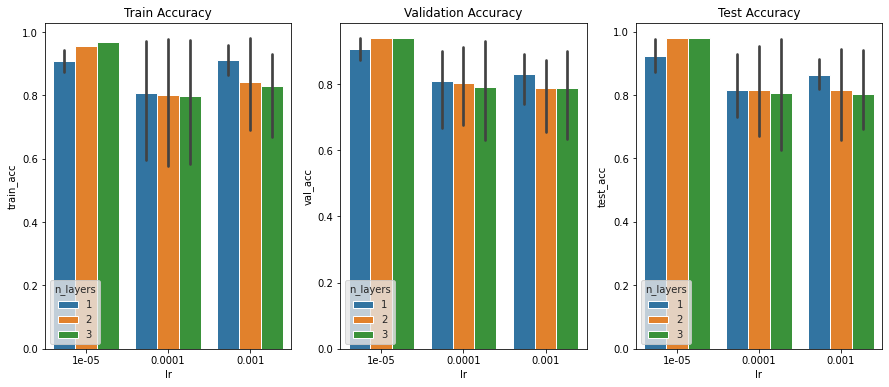

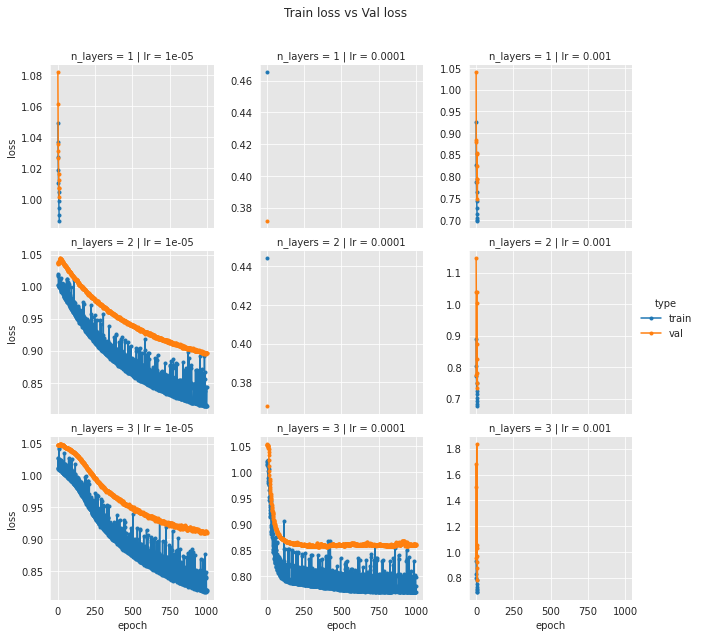

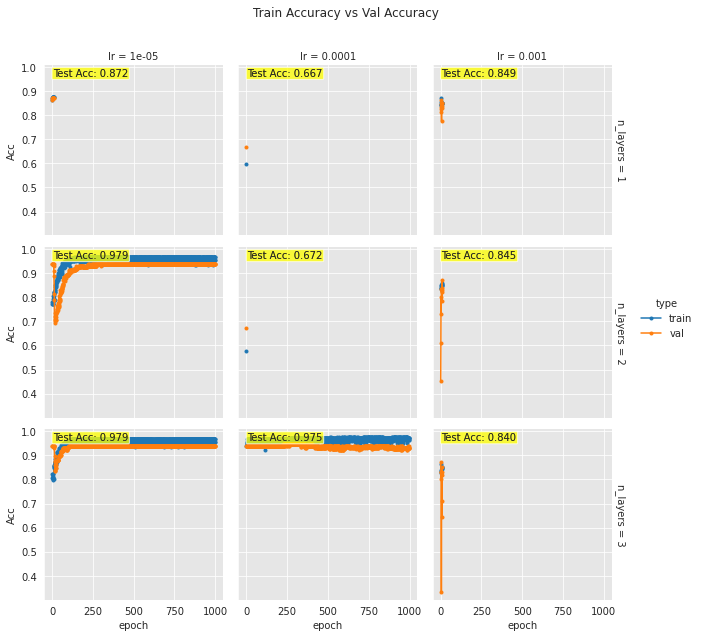

In [19]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

In [32]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    tt = confusion[0,0]
    tf = confusion[0,1]
    ft = confusion[1,0]
    ff = confusion[1,1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='weighted') # None, 'micro', 'macro', 'weighted'
    recall = recall_score(y_test, y_pred,average='weighted')
    F1 = f1_score(y_test, y_pred,average='weighted')
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))    
    print('양성예측율: {:.4f}'.format(tt/(tt+tf)))
    print('음성예측율: {:.4f}'.format(ff/(ft+ff)))    
    print('F1: {:.4f}'.format(F1))

In [33]:
prediction = np.where(prediction >= 0.5, 1, 0)
get_clf_eval(y_true, prediction)

오차행렬:
 [[3630    2]
 [  25    0]]

정확도: 0.9926
정밀도: 0.9864
재현율: 0.9926
양성예측율: 0.0000
음성예측율: 0.0006
F1: 0.9895
